# **Project Name:** Time series Forecasting using LSTM
**Application:** Predicting new covid-19  positive cases  for next few days in india

Dheeraj Kumar Bharti
(M.tech||IITG||SPML)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [30]:

confirmed_cases = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

In [31]:
confirmed_cases.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,7/25/21,7/26/21,7/27/21,7/28/21,7/29/21,7/30/21,7/31/21,8/1/21,8/2/21,8/3/21,8/4/21,8/5/21,8/6/21,8/7/21,8/8/21,8/9/21,8/10/21,8/11/21,8/12/21,8/13/21,8/14/21,8/15/21,8/16/21,8/17/21,8/18/21,8/19/21,8/20/21,8/21/21,8/22/21,8/23/21,8/24/21,8/25/21,8/26/21,8/27/21,8/28/21,8/29/21,8/30/21,8/31/21,9/1/21,9/2/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,143439,144285,145008,145552,145996,146523,146523,146523,147985,148572,148933,149361,149810,149810,149810,150778,151013,151291,151563,151770,151770,151770,152142,152243,152363,152411,152448,152448,152448,152583,152660,152722,152822,152960,152960,152960,153148,153220,153260,153306
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,132875,132891,132922,132952,132999,133036,133081,133121,133146,133211,133310,133442,133591,133730,133912,133981,134201,134487,134761,135140,135550,135947,136147,136598,137075,137597,138132,138790,139324,139721,140521,141365,142253,143174,144079,144847,145333,146387,147369,148222
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,162155,163660,165204,167131,168668,170189,171392,172564,173922,175229,176724,178013,179216,180356,181376,182368,183347,184191,185042,185902,186655,187258,187968,188663,189384,190078,190656,191171,191583,192089,192626,193171,193674,194186,194671,195162,195574,196080,196527,196915
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,14498,14577,14586,14586,14655,14678,14678,14678,14747,14766,14797,14809,14836,14836,14836,14836,14873,14891,14908,14924,14924,14924,14954,14960,14976,14981,14988,14988,14988,15002,15003,15014,15016,15025,15025,15025,15032,15033,15046,15052
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,41780,41879,42110,42288,42486,42646,42777,42815,42970,43070,43158,43269,43487,43592,43662,43747,43890,43998,44174,44328,44534,44617,44739,44972,45175,45325,45583,45817,45945,46076,46340,46539,46726,46929,47079,47168,47331,47544,47781,48004


In [65]:
confirmed_cases.describe()

,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,...,7/25/21,7/26/21,7/27/21,7/28/21,7/29/21,7/30/21,7/31/21,8/1/21,8/2/21,8/3/21,8/4/21,8/5/21,8/6/21,8/7/21,8/8/21,8/9/21,8/10/21,8/11/21,8/12/21,8/13/21,8/14/21,8/15/21,8/16/21,8/17/21,8/18/21,8/19/21,8/20/21,8/21/21,8/22/21,8/23/21,8/24/21,8/25/21,8/26/21,8/27/21,8/28/21,8/29/21,8/30/21,8/31/21,9/1/21,9/2/21
count,277.000000,277.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,...,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02,2.790000e+02
mean,20.305266,22.500100,1.996416,2.347670,3.372760,5.136201,7.591398,10.491039,19.992832,22.103943,29.516129,35.580645,43.146953,60.168459,71.279570,85.655914,99.078853,110.405018,123.283154,133.082437,143.942652,153.293907,160.612903,162.111111,216.422939,239.817204,247.498208,255.322581,262.616487,269.362007,271.154122,273.161290,275.415771,281.727599,283.089606,285.111111,288.172043,291.673835,296.544803,301.512545,...,6.959822e+05,6.979310e+05,7.001253e+05,7.024323e+05,7.047676e+05,7.074076e+05,7.092318e+05,7.108922e+05,7.129959e+05,7.152926e+05,7.176984e+05,7.201637e+05,7.231065e+05,7.250593e+05,7.266268e+05,7.289923e+05,7.312656e+05,7.337995e+05,7.362548e+05,7.393607e+05,7.412490e+05,7.428981e+05,7.452986e+05,7.476603e+05,7.501955e+05,7.526921e+05,7.557878e+05,7.577089e+05,7.592984e+05,7.617969e+05,7.641803e+05,7.667209e+05,7.692745e+05,7.722305e+05,7.741620e+05,7.757488e+05,7.782074e+05,7.803165e+05,7.829078e+05,7.851716e+05
std,25.206138,75.408236,26.637656,26.735265,33.284971,46.326447,64.742529,87.231432,214.047295,215.362435,296.778990,351.860532,432.981669,672.864127,813.397923,1002.471555,1181.334181,1327.975179,1498.072088,1626.683092,1778.106467,1903.580090,2001.624224,2001.962023,2888.441265,3259.166926,3369.459866,3485.112533,3593.210944,3694.489864,3715.396732,3739.969404,3753.204644,3838.236060,3838.277974,3850.497244,3880.393819,3904.575241,3929.608485,3949.608800,...,3.143256e+06,3.149140e+06,3.155427e+06,3.161816e+06,3.168483e+06,3.179478e+06,3.183976e+06,3.187670e+06,3.194997e+06,3.202375e+06,3.209558e+06,3.217437e+06,3.230797e+06,3.235807e+06,3.239079e+06,3.248601e+06,3.255905e+06,3.264487e+06,3.272481e+06,3.287089e+06,3.291674e+06,3.295484e+06,3.305824e+06,3.313907e+06,3.322608e+06,3.331204e+06,3.346804e+06,3.351888e+06,3.355259e+06,3.366375e+06,3.374761e+06,3.383970e+06,3.393636e+06,3.409588e+06,3.414730e+06,3.418813e+06,3.431195e+06,3.439622e+06,3.450818e+06,3.459894e+06
min,-51.796300,-178.116500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0

Total days in the dataset 590


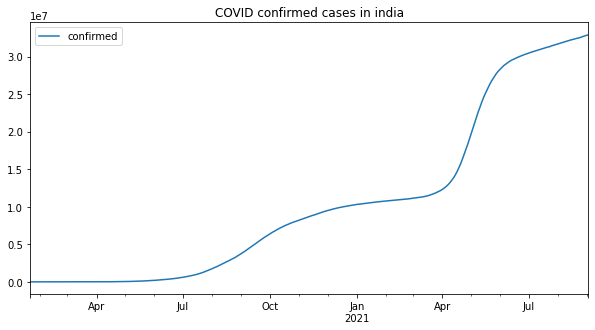

In [54]:
country = 'India'
confirmed_cases_india = confirmed_cases[confirmed_cases["Country/Region"] == country]
confirmed_cases_india = pd.DataFrame(confirmed_cases_india[confirmed_cases_india.columns[4:]].sum(),columns=["confirmed"])
confirmed_cases_india.index = pd.to_datetime(confirmed_cases_india.index,format='%m/%d/%y')

confirmed_cases_india.plot(figsize=(10,5),title="COVID confirmed cases in india")

confirmed_cases_india.tail(10)

print("Total days in the dataset", len(confirmed_cases_india))

#Use data until 14 days before as training
x = len(confirmed_cases_india)-8

train=confirmed_cases_india.iloc[:x]
test = confirmed_cases_india.iloc[x:]


In [55]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train) 

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)


In [56]:
from keras.preprocessing.sequence import TimeseriesGenerator
seq_size = 7  ## number of steps (lookback)
n_features = 1 ## number of features. This dataset is univariate so it is 1
train_generator = TimeseriesGenerator(train_scaled, train_scaled, length = seq_size, batch_size=1)
print("Total number of samples in the original training data = ", len(train)) # 271
print("Total number of samples in the generated data = ", len(train_generator)) # 264 with seq_size=7


Total number of samples in the original training data =  582
Total number of samples in the generated data =  575


In [57]:
x,y = train_generator[10]  #Check train_generator
test_generator = TimeseriesGenerator(test_scaled, test_scaled, length=seq_size, batch_size=1)
print("Total number of samples in the original training data = ", len(test)) # 10 as we're using last 14 days for test
print("Total number of samples in the generated data = ", len(test_generator)) # 7
#Check data shape from generator
x,y = test_generator[0]


Total number of samples in the original training data =  8
Total number of samples in the generated data =  1


In [58]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation

#Define Model 
model = Sequential()
model.add(LSTM(150, activation='relu', return_sequences=True, input_shape=(seq_size, n_features)))
model.add(LSTM(64, activation='relu'))
model.add(Dense(64))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 7, 150)            91200     
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                55040     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 150,465
Trainable params: 150,465
Non-trainable params: 0
_________________________________________________________________


In [59]:
history = model.fit_generator(train_generator, 
                              validation_data=test_generator, 
                              epochs=80, steps_per_epoch=10)

Epoch 1/80


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


10/10 [==============================] - 3s 60ms/step - loss: 0.0843 - val_loss: 0.4965
Epoch 2/80
10/10 [==============================] - 0s 15ms/step - loss: 0.0301 - val_loss: 0.1642
Epoch 3/80
10/10 [==============================] - 0s 18ms/step - loss: 0.0229 - val_loss: 0.0477
Epoch 4/80
10/10 [==============================] - 0s 14ms/step - loss: 0.0273 - val_loss: 0.1144
Epoch 5/80
10/10 [==============================] - 0s 13ms/step - loss: 0.0086 - val_loss: 0.0420
Epoch 6/80
10/10 [==============================] - 0s 13ms/step - loss: 0.0046 - val_loss: 0.0015
Epoch 7/80
10/10 [==============================] - 0s 16ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 8/80
10/10 [==============================] - 0s 15ms/step - loss: 0.0012 - val_loss: 6.8157e-06
Epoch 9/80
10/10 [==============================] - 0s 14ms/step - loss: 9.0973e-04 - val_loss: 8.2207e-04
Epoch 10/80
10/10 [==============================] - 0s 15ms/step - loss: 6.5174e-04 - val_loss: 7.0503e-04


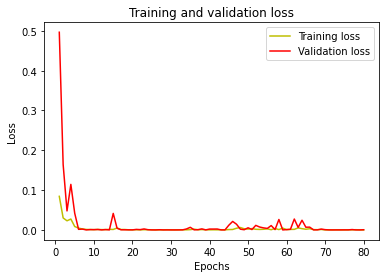

In [60]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [61]:
#forecast
prediction = [] #Empty list to populate later with predictions

current_batch = train_scaled[-seq_size:] #Final data points in train 
current_batch = current_batch.reshape(1, seq_size, n_features) #Reshape

In [62]:
future = 7 #Days
for i in range(len(test) + future):
    current_pred = model.predict(current_batch)[0]
    prediction.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)


In [63]:

### Inverse transform to before scaling so we get actual numbers
rescaled_prediction = scaler.inverse_transform(prediction)

time_series_array = test.index  #Get dates for test data

#Add new dates for the forecast period
for k in range(0, future):
    time_series_array = time_series_array.append(time_series_array[-1:] + pd.DateOffset(1))


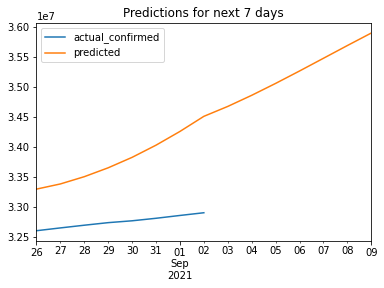

In [64]:
#Create a dataframe to capture the forecast data
df_forecast = pd.DataFrame(columns=["actual_confirmed","predicted"], index=time_series_array)

df_forecast.loc[:,"predicted"] = rescaled_prediction[:,0]
df_forecast.loc[:,"actual_confirmed"] = test["confirmed"]

#Plot
df_forecast.plot(title="Predictions for next 7 days")
